Two ways to reduce dimensionality:   
(1) Feature selection: select a subset of features   
(2) Feature extraction: construct new but fewer features

## Sequential backward selection (SBS)
Idea: remove features until the desired number of features are left.   
We define a criterion function J, which we hope to maximize at each removal.  
Outline of SBS algorithm:   
(1) Starting from the full feature space $X_d$.   
(2) Determin the feature $x^-$ that maximize $x^- = argmaxJ(X_d-x)$. Then get $X_{d-1}=X_d-x^-$.   
(3) Repeat (2) until the desired number of feature is reached.   
J can be 'performance before removal - performance after removal'. Assume that the performance is better when there are more features. Then J is a lost of performance due to removal. By maximizing J, we get the feature that causes the least performance lost.   
   
In the following codes, at each iteration, we drop a feature and calculate the accuracy score. We drop the feature corresponding to the highest score, which means we best maintain the performance of the model by removing the feature.


In [1]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd
# For data splitting
from sklearn.model_selection import train_test_split
# For min-max rescaling
from sklearn.preprocessing import MinMaxScaler
# For standardization
from sklearn.preprocessing import StandardScaler

In [67]:
class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        # Construct a new unfitted estimator with the same parameters.
        self.estimator = clone(estimator)
        # Desired number of features
        self.k_features = k_features
        # Note that by default scoring=accuracy_score, which is a function from sklearn.
        # It is not a variable!
        self.scoring = scoring
        # Proportion of data in the test set
        self.test_size = test_size
        # Used to give consistent result
        self.random_state =random_state
    
    def fit(self, X, y):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        # Get the total number of features
        dim = X_train.shape[1]
        # Create a tuple of indices 
        self.indices_ = tuple(range(dim)) #??? Perhaps list can also be used instead of tuple?
        self.subsets_ = [self.indices_]
        # Calculate the score
        # Note that _calc_score contains fitting the model to the training data
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        # Store the score
        self.scores_ = [score]
        
        
        while dim > self.k_features:
            # List to store the scores of all combination of indices
            scores = []
            # List to store all index combinations
            subsets = []
            
            # Remove a feature and consider the rest
            # For each combination, calculate the score, save the score and the combination
            for p in combinations(self.indices_, r=dim-1):
                # Calculate the score for the current combination
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                # Store the score for the current combination
                scores.append(score)
                # Store the current combination
                subsets.append(p)
            
            # Return the index for the best score
            idx_best = np.argmax(scores)
            # Get the best index combination
            self.indices_ = subsets[idx_best]
            # Store the best combination
            self.subsets_.append(self.indices_)
            # Store the current best scores
            self.scores_.append(scores[idx_best])
            
            dim -= 1
            
        # Save the score for the desired number of features
        self.k_score_ = self.scores_[-1] 
        
        
        return self
        
        
        
        
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        # Train the model and calculate the accuracy score 
        
        # Train the model with only a subset of features specified by 'indices'
        # X_train is a numpy 2D array which can be indexed by tuples and lists.
        self.estimator.fit(X_train[:, indices], y_train)
        
        # Make predictions
        y_pred = self.estimator.predict(X_test[:, indices])
        
        # Calculate the score
        # Note that self.scoring is a function
        score = self.scoring(y_test, y_pred)
        return score
    
    def transform(self, X):
        # Drop the features not in self.indices
        return X[:, self.indices_]
        
        
        

In [3]:
# Read the online wine data set with no headers
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

# Assign column labels
# The feature names can be found online.
df_wine.columns = ['Class label', 
              'Alcohol', 
              'Malic acid', 
              'Ash', 
              'Alcalinity of ash', 
              'Magnesium', 
              'Total phenols', 
              'Flavanoids', 
              'Nonflavanoid phenols', 
              'Proanthocyanins', 
              'Color intensity', 
              'Hue', 
              'OD280/OD315 of diluted wines', 
              'Proline']

# Split the data set into a training set and a test set
y = df_wine.iloc[:, 0].values
X = df_wine.iloc[:, 1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
# test_size=0.3: the testing set contains 30% data
# stratify=y: both the train and testing sets have the same class proportions as the original dataset.

# Standardization
# Create a scaler
stdsc = StandardScaler()
# Fit and transform the training set
X_train_std = stdsc.fit_transform(X_train)
# Transform the testing set with the same scaler
X_test_std = stdsc.transform(X_test)

In [63]:
# Test k-nearest neighbor classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_std, y_train)

KNeighborsClassifier()

In [64]:
y_pred = knn.predict(X_test)
# There is a warning when using knn

C:\Users\bai_f\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [68]:
# Implememt sequential feature selection
knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

C:\Users\bai_f\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\bai_f\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Text(0.5, 0, 'Number of features')

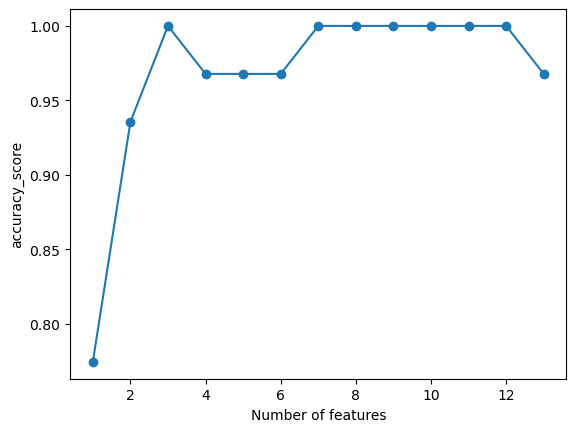

In [72]:
# Plot the accuracy scores for all dimensions
k_feat = [len(k) for k in sbs.subsets_]

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(k_feat, sbs.scores_, marker='o')
ax.set_ylabel("accuracy_score")
ax.set_xlabel("Number of features")

In [89]:
# Get the features for dim=3
k3 = list(sbs.subsets_[10])
print(k3)
print(df_wine.columns)
print(df_wine.columns[1:])
print(df_wine.columns[1:][k3]) 
# Note that we need to convert k3 into a list. 
# Otherwise the k3 tuple itself means three dimensions to pandas

[0, 1, 11]
Index(['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
       'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')
Index(['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
       'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')
Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [88]:
# Accuracy of knn on the orignal dataset
knn.fit(X_train_std, y_train)
print("Training accuracy", knn.score(X_train_std, y_train))
print("Test accuracy", knn.score(X_test_std, y_test))

Training accuracy 0.967741935483871
Test accuracy 0.9629629629629629


C:\Users\bai_f\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\bai_f\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [91]:
knn.fit(X_train_std[:,k3], y_train)
print("Training accuracy", knn.score(X_train_std[:,k3], y_train))
print("Test accuracy", knn.score(X_test_std[:,k3], y_test))

Training accuracy 0.9516129032258065
Test accuracy 0.9259259259259259


C:\Users\bai_f\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\bai_f\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim